In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

# random.seed(33)

dataset_name = "Twitter15-TF"
unique_name = "BERT_Finetuned"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Twitter15-TF_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(742, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2
0,551099691702956032,rip elly may clampett: so sad to learn #beverl...,True,training
1,514106273852174337,just in: missing afghan soldiers found trying ...,True,training
2,495366618818830336,#riphulkhogan my heart is ripping like your sh...,False,training
3,532206910796468224,a chick-fil-a manager allegedly banned this hi...,False,training
4,560187970389819392,islamic tribunal using sharia law in texas has...,False,validation


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(514, 768)
(165, 768)
(63, 768)
(514,)
(165,)
(63,)


In [8]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Linear(128, n_output),
#             nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [9]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from library.classification import SKLearnClassification
from library.evaluation import ConfusionMatrix

logres_model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr', max_iter=10000)
neigh = KNeighborsClassifier(n_neighbors=3)
svm = LinearSVC()

models = [
    SKLearnClassification(logres_model, "Logistic Regression"),
    SKLearnClassification(neigh, "K-Nearest Neighbor"),
    SKLearnClassification(svm, "Support Vector Machine"),
]
# for model in models:
#     print(f"\n--- {model.model_name.upper()} ---")
#     model.train(train_vectors, train_labels, dataset_name)
    
#     print("Validation Set")
#     preds = model.predict(val_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=val_labels,
#         predictions=preds,
#         binary=True
#     )
#     conf_mat.evaluate()
    
#     print("Test Set")
#     preds = model.predict(test_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=test_labels,
#         predictions=preds,
#         binary=False
#     )
#     conf_mat.evaluate(classes=labels_str)

#     print("--- END ---\n")

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 95.152
-- Epoch 50, Train Loss : 0.00030322345992317423, Test Loss : 0.3314320147037506
-- Epoch 100, Train Loss : 6.921836757101119e-05, Test Loss : 0.3933781385421753
-- Epoch 150, Train Loss : 3.0068899377511116e-05, Test Loss : 0.4314737915992737
-- Epoch 200, Train Loss : 1.6671435673742963e-05, Test Loss : 0.45947518944740295
-- Epoch 250, Train Loss : 1.0585909706151142e-05, Test Loss : 0.4818979501724243
-- Epoch 300, Train Loss : 7.283938828095415e-06, Test Loss : 0.5006394386291504
-- Epoch 350, Train Loss : 5.297427804862309e-06, Test Loss : 0.516839861869812
-- Epoch 400, Train Loss : 3.9633191519783395e-06, Test Loss : 0.5310936570167542
-- Epoch 450, Train Loss : 3.1199131100834165e-06, Test Loss : 0.5439984202384949
-- Epoch 500, Train Loss : 2.513473411625e-06, Test Loss : 0.5558858513832092
-- Epoch 550, Train Loss : 1.957990434675594e-06, Test Loss : 0.5664154291152954
-

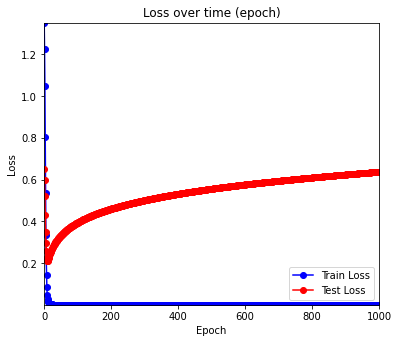

Exec Time : 28.23 seconds

Validation Set
Predictions : torch.Size([165])
165 vs 165
Multi Class Evaluation

Class True Evaluation
- Precision : 93.258 %
- Recall : 97.647 %
- F1 : 0.95402

Class False Evaluation
- Precision : 97.368 %
- Recall : 92.5 %
- F1 : 0.94872

Combined Evaluation
- Accuracy : 95.152 %
- Precision : 95.313 %
- Recall : 95.074 %
- F1 : 0.95193

- Average Confidence : 100.0 %
Model, Combined,,,,True,,,False,,,
Twitter15-TF_4LayerNet_BERT_Finetuned Validation, 95.152, 95.313, 95.074, 0.95193, 93.258, 97.647, 0.95402, 97.368, 92.5, 0.94872, 

Test Set
Predictions : torch.Size([63])
63 vs 63
Multi Class Evaluation

Class True Evaluation
- Precision : 90.909 %
- Recall : 100.0 %
- F1 : 0.95238

Class False Evaluation
- Precision : 100.0 %
- Recall : 90.909 %
- F1 : 0.95238

Combined Evaluation
- Accuracy : 95.238 %
- Precision : 95.455 %
- Recall : 95.455 %
- F1 : 0.95455

- Average Confidence : 100.0 %
Model, Combined,,,,True,,,False,,,
Twitter15-TF_4LayerNet_BERT_F

In [10]:
print("Multiclass Classification using 4-Layer Linear Network")
start = time.time()
model_name = f"{dataset_name}_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)